<a href="https://colab.research.google.com/github/tamtran4869/marketing_effectiveness_analysis/blob/main/Root_cause_analysis_dowhy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Root Cause Analysis with dowhy
Beside estimating treatment effects, causal inference also includes finding root cause of unsual observations, or strange trends in data. the `dowhy` package is a good package for these tasks.

In [ ]:
%%capture
!pip install dowhy
!pip install cdt

In [ ]:
import matplotlib.pyplot as plt

import numpy as np, pandas as pd, networkx as nx
from dowhy import gcm
from dowhy.gcm.falsify import falsify_graph
from dowhy.utils import plot, bar_plot
import graphviz
np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)

In [ ]:
#Importing the data
url='https://drive.google.com/file/d/1DgCbbBVhn0JSc4dD4MOOPyGm8pHVqaRk/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df = pd.read_csv(url)
df = df.drop(['Locate_H','Day'],axis=1)
#df  = df[df["Date"].str.startswith(tuple(['2013','2014','2015']), na=False)]
df = df.drop_duplicates()
# Convert treatment values to 0 for No Offer and 1 for Buy One Get One
df['Type_H'] = df['Type_H'].apply(lambda x: 0 if x =='Normal' or x=='Work Day'or x == 'Transfer' else 1)
df.head()

,Date,Family,Sales,Onpromotion,Transactions,Oil,Type_H,Month,Weekday,Y_M
0,2013-01-01,Automotive,0.0,0,0,93.14,1,1,1,2013-01
1,2013-01-01,BabyCare,0.0,0,0,93.14,1,1,1,2013-01
2,2013-01-01,Beauty,0.0,0,0,93.14,1,1,1,2013-01
3,2013-01-01,Beverages,0.0,0,0,93.14,1,1,1,2013-01
4,2013-01-01,Books,0.0,0,0,93.14,1,1,1,2013-01


In [ ]:
# Group data -> dataframe with 1 day per row
df = df.groupby(['Date','Y_M']).agg({'Sales':'sum',
                                      'Onpromotion':'sum',
                                      'Transactions':'mean',
                                      'Oil':'mean',
                                      'Weekday':pd.Series.mode,
                                      'Month':pd.Series.mode,
                                      'Type_H': 'max'}).reset_index()
df.head()

,Date,Y_M,Sales,Onpromotion,Transactions,Oil,Weekday,Month,Type_H
0,2013-01-01,2013-01,0.000000,0,0.0,93.14,1,1,1
1,2013-01-02,2013-01,7417.148000,0,2111.0,93.14,2,1,0
2,2013-01-03,2013-01,5873.244001,0,1833.0,92.97,3,1,0
3,2013-01-04,2013-01,5919.879001,0,1863.0,93.12,4,1,0
4,2013-01-05,2013-01,6318.785010,0,1509.0,93.20,5,1,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1684 entries, 0 to 1683
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          1684 non-null   object 
 1   Y_M           1684 non-null   object 
 2   Sales         1684 non-null   float64
 3   Onpromotion   1684 non-null   int64  
 4   Transactions  1684 non-null   float64
 5   Oil           1684 non-null   float64
 6   Weekday       1684 non-null   int64  
 7   Month         1684 non-null   int64  
 8   Type_H        1684 non-null   int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 118.5+ KB


In [ ]:
df.describe()

,Sales,Onpromotion,Transactions,Oil,Weekday,Month,Type_H
count,1684.000000,1684.000000,1684.000000,1684.000000,1684.000000,1684.000000,1684.000000
mean,8474.620231,82.649050,1516.605107,67.862162,2.997031,6.207838,0.142518
std,3620.684322,111.437903,513.196481,25.711860,2.001334,3.386673,0.349684
min,0.000000,0.000000,0.000000,26.190000,0.000000,1.000000,0.000000
25%,5605.217002,0.000000,1320.750000,46.320000,1.000000,3.000000,0.000000
50%,8559.911498,21.000000,1746.000000,53.190000,3.000000,6.000000,0.000000
75%,11089.217000,151.000000,1831.250000,95.802500,5.000000,9.000000,0.000000
max,31877.404000,598.000000,3023.000000,110.620000,6.000000,12.000000,1.000000


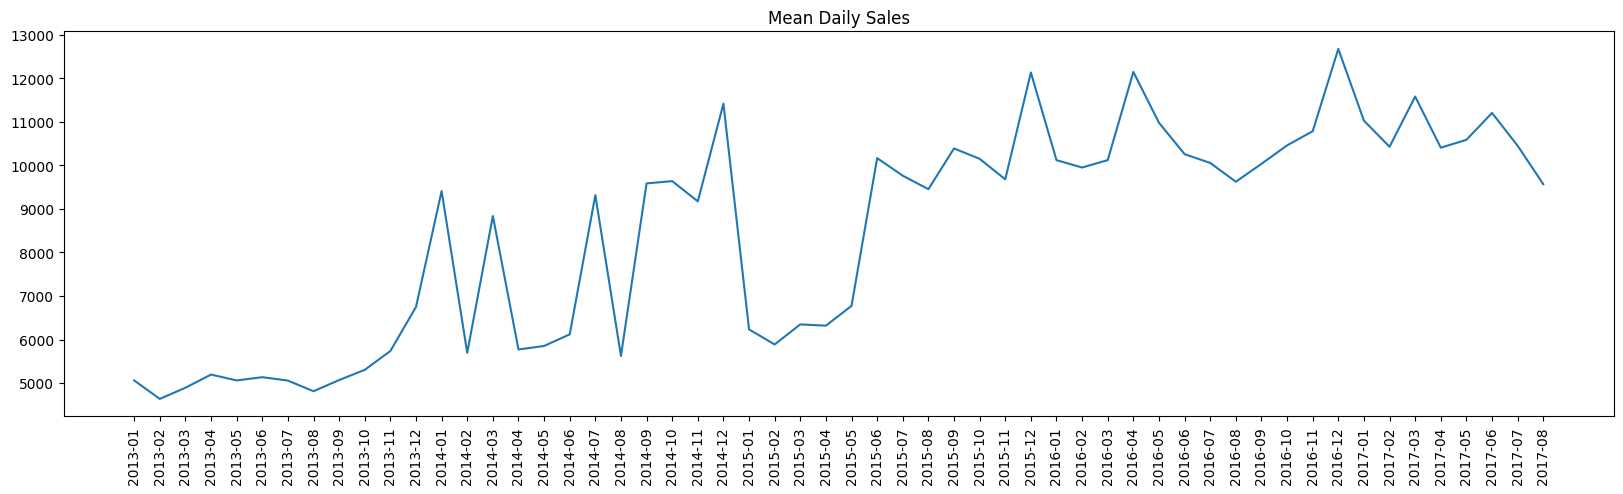

In [ ]:
# Get mean daily sales plot
s=df.groupby('Y_M')['Sales'].mean()
plt.rcParams['figure.figsize'] = [20, 5]
plt.xticks(rotation=90)
plt.title('Mean Daily Sales')
plt.plot(s.index,s)

<BarContainer object of 56 artists>

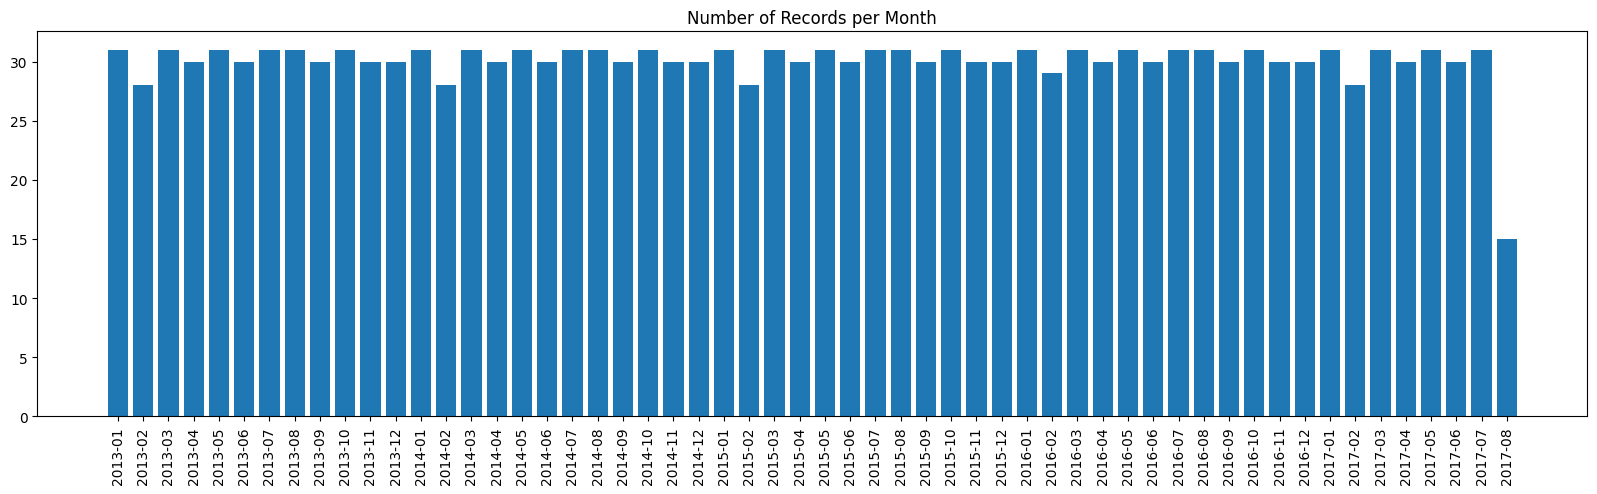

In [ ]:
# Get observation counts per month plot
s = df.groupby(['Y_M']).count().reset_index()
s = s.groupby('Y_M')['Date'].mean()
plt.rcParams['figure.figsize'] = [20, 5]
plt.xticks(rotation=90)
plt.title('Number of Records per Month')
plt.bar(s.index,s)

There is data for only half month of Aug 2017. Then it is should be removed for a fair comparison.

In [ ]:
# Remove data in Aug 2017 and unused features.
df = df[df['Y_M']!='2017-08']
d = df.drop(['Date','Y_M'],axis=1)
d.head()

,Sales,Onpromotion,Transactions,Oil,Weekday,Month,Type_H
0,0.000000,0,0.0,93.14,1,1,1
1,7417.148000,0,2111.0,93.14,2,1,0
2,5873.244001,0,1833.0,92.97,3,1,0
3,5919.879001,0,1863.0,93.12,4,1,0
4,6318.785010,0,1509.0,93.20,5,1,0


# Causal Graph

A causal direct acyclic graph (DAG) is needed to run models in `dowhy` packages.
The graph could be based on domain knowledge or using functions to explore. In this case, the graph is based on domain knowledge.

The graph is built with some ideas:
- People go to stores more on holiday and weekend -> increase transactions.
- Low price oils -> reduce product cost & living cost -> people tends to buy more + the store has extra budget for marketing.
- Festive months have more promotions.

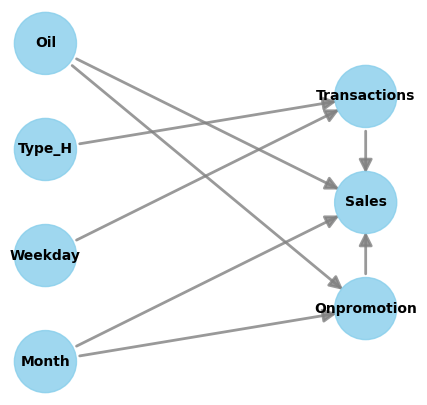

In [ ]:
G = nx.DiGraph([('Transactions','Sales'),
                ('Oil','Sales'),
                ('Onpromotion','Sales'),
                ('Type_H','Transactions'),
                ('Weekday','Transactions'),
                ('Month','Sales'),
                ('Month','Onpromotion'),
                ('Oil','Onpromotion')])
plot(G)

Next is to check the graph.
The `falsify_graph` is used for that purpose.
It tests each of the conditional independence constraints implied by the graph, known as the local Markov conditions (LMCs).
For example: `Sales` is conditional independent of `Weekday` given `Transactions`. It means `Weekday` does not affect `Sales` if `Transactions` is known.

The function gave results for 2 tests:
- The first measures whether the LMCs implied by the graph are satisfied by the data.
-  The second test (tPa) checks whether the graph is falsifiable.

In [ ]:
# causal_graph is a networkx digraph
result = falsify_graph(G, d, show_progress_bar=False)
print(result)

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


+-------------------------------------------------------------------------------------------------------+
|                                         Falsificaton Summary                                          |
+-------------------------------------------------------------------------------------------------------+
| The given DAG is informative because 0 / 20 of the permutations lie in the Markov                     |
| equivalence class of the given DAG (p-value: 0.00).                                                   |
| The given DAG violates 11/24 LMCs and is better than 100.0% of the permuted DAGs (p-value: 0.00).     |
| Based on the provided significance level (0.05) and because the DAG is informative,                   |
| we do not reject the DAG.                                                                             |
+-------------------------------------------------------------------------------------------------------+


The result shows we could use the graph.

# Root cause analysis tasks
## Anomaly Attribution

This task is to answer the question: "How much did each of the upstream nodes and the target node (`Sales`) contribute to the observed anomaly?"


In [ ]:
# Get some samples of anomoly data (sales > 70% of max sales)
anomalous_data = d[d['Sales']>=d['Sales'].max()*0.7]
d = d[~d.index.isin(anomalous_data.index)]

anomalous_data

,Sales,Onpromotion,Transactions,Oil,Weekday,Month,Type_H
719,27486.61600,30,2594.0,55.25,0,12,1
1083,29692.14201,76,2612.0,36.12,1,12,1
1203,27275.55800,216,1852.0,43.18,3,4,1
1219,25702.82400,186,1486.0,43.45,5,5,1
1408,22626.19800,468,1448.0,43.29,5,11,1
1448,31877.40400,568,2760.0,51.98,3,12,1


A graphical causal model(GCM) includes a DAG of variables and a causal mechanism for each variable. GCM in dowhy divided into 3 types based on causal mechanisms:

- `ProbabilisticCausalModel`(PCM): stochastic models (parents nodes) and conditional stochastic models.
- `StructuralCausalModel` (SCM): stochastic models (parents nodes) and functional causal models Y = f(X,N) with N: Noise (Y depends on X and unobserved N).
- `InvertibleStructuralCausalModel`(ISCM): stochastic models (parents nodes) and an additive noise model Y = f'(X) + N with N: Noise (Y solely determined by X, and there is some additional noise N added to the result. In this way, from observed data X and Y, we can reconstruct N as residual).

PCM is used for association (prediction task) and intervention causality (estimate treatment effect) while SCMs are used for association, intervention and counterfactuals (estimate counterfactual outcomes of observed data).

In this case, we use InvertibleStructuralCausalModel since we need to analyse the root cause which requires counterfactual computations.

If we have prior knowledge about the distribution of parent nodes and their relationship with child nodes, we can manually define causal mechanisms. In this case, the auto-assign function is used.

In [ ]:
# Define and fit a causal model
causal_model = gcm.InvertibleStructuralCausalModel(G)
gcm.auto.assign_causal_mechanisms(causal_model, d) # Auto assign mechenisms
gcm.fit(causal_model, d)
'''
from scipy.stats import uniform, multivariate_normal,poisson
causal_model.set_causal_mechanism('Sales', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
causal_model.set_causal_mechanism('Onpromotion', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
causal_model.set_causal_mechanism('Transactions', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
causal_model.set_causal_mechanism('Oil', gcm.ScipyDistribution(norm))
causal_model.set_causal_mechanism('Month', gcm.ScipyDistribution(uniform))
causal_model.set_causal_mechanism('Weekday', gcm.ScipyDistribution(uniform))
causal_model.set_causal_mechanism('Type_H', gcm.ScipyDistribution(uniform))
'''

Fitting causal mechanism of node Month: 100%|██████████| 7/7 [00:00<00:00, 15.85it/s]


"\nfrom scipy.stats import uniform, multivariate_normal,poisson\ncausal_model.set_causal_mechanism('Sales', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))\ncausal_model.set_causal_mechanism('Onpromotion', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))\ncausal_model.set_causal_mechanism('Transactions', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))\ncausal_model.set_causal_mechanism('Oil', gcm.ScipyDistribution(norm))\ncausal_model.set_causal_mechanism('Month', gcm.ScipyDistribution(uniform))\ncausal_model.set_causal_mechanism('Weekday', gcm.ScipyDistribution(uniform))\ncausal_model.set_causal_mechanism('Type_H', gcm.ScipyDistribution(uniform))\n"

Estimating Shapley Values. Average change of Shapley values in run 95 (475 evaluated permutations): 0.7264040934313227%: 100%|██████████| 1/1 [00:30<00:00, 30.87s/it]


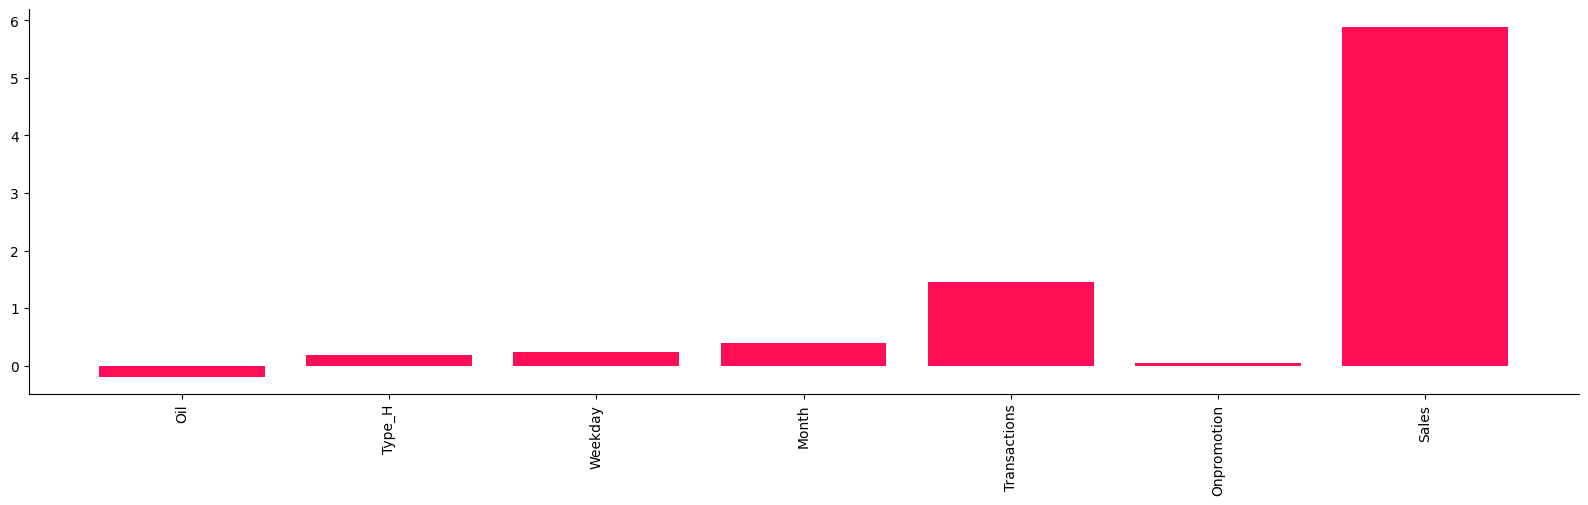

In [ ]:
# Get attributions
attribution_scores = gcm.attribute_anomalies(causal_model, 'Sales', anomaly_samples=anomalous_data)
bar_plot({k:v[0] for k,v in attribution_scores.items()})

`Sales` have the highest attribution to anomalous data. It may indicate there are some hidden features. Next is the number of transactions and month.

In [ ]:
# Statistics of anomalous data
anomalous_data[['Sales','Transactions','Month']].describe()

,Sales,Transactions,Month
count,6.000000,6.000000,6.000000
mean,27443.457002,2125.333333,9.333333
std,3193.189959,600.255501,3.777124
min,22626.198000,1448.000000,4.000000
25%,26096.007500,1577.500000,6.500000
50%,27381.087000,2223.000000,11.500000
75%,29140.760507,2607.500000,12.000000
max,31877.404000,2760.000000,12.000000


In [ ]:
# Statictics of training data
d[['Sales','Transactions','Month']].describe()

,Sales,Transactions,Month
count,1663.000000,1663.000000,1663.000000
mean,8396.326412,1515.223091,6.180397
std,3442.281674,511.661692,3.392130
min,0.000000,0.000000,1.000000
25%,5596.237500,1320.500000,3.000000
50%,8407.379011,1746.000000,6.000000
75%,11069.858500,1831.000000,9.000000
max,21788.900000,3023.000000,12.000000


It is clear that outlier data have higher sales, transactions and average months.

## Change Attribution

To answer the question: "Which node in my data behaves differently?"

Have a look at the mean daily sales time series graph again.

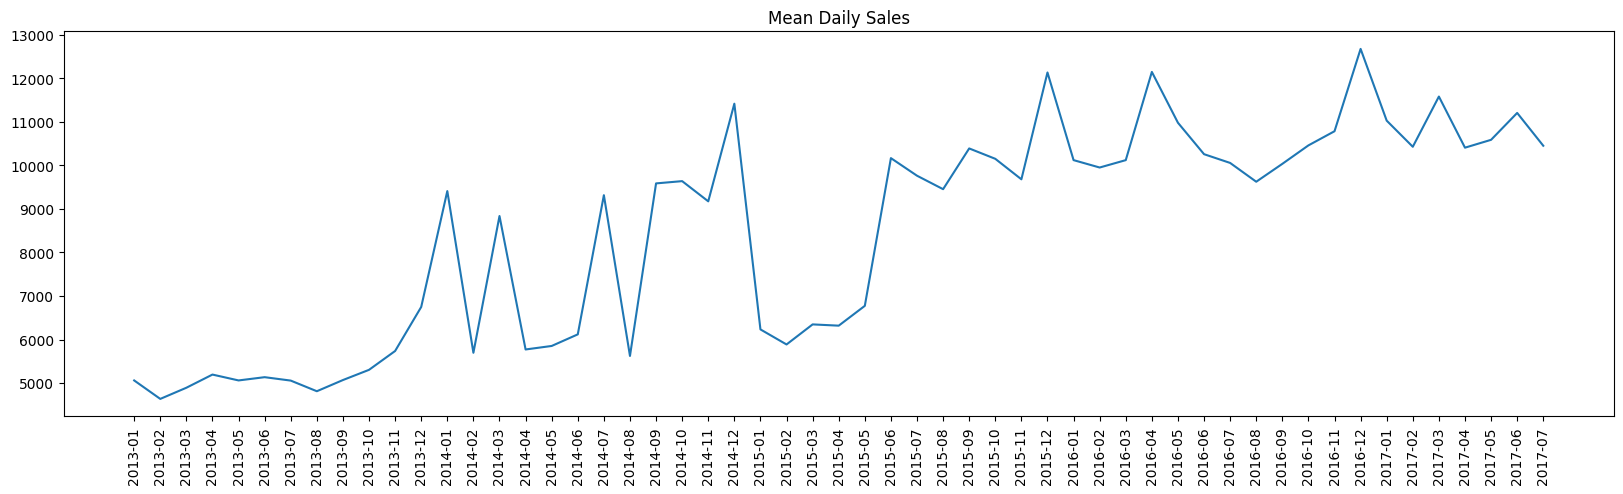

In [ ]:
# Mean Daily Sales Time Series
s=df.groupby('Y_M')['Sales'].mean()
plt.rcParams['figure.figsize'] = [20, 5]
plt.xticks(rotation=90)
plt.title('Mean Daily Sales')
plt.plot(s.index,s)

It is clear that from June 2015 to August 2017, mean daily sales were high and more stable than in the previous period. To find the causes behind that change, we need to split data into 2 dataframes, fit one dataframe into the causal model and then use `distribution_change` function.

In [ ]:
# Data from begining to May 2015
d_1 = df[df["Date"].str.startswith(tuple(['2015-01','2015-02','2015-03','2015-04','2015-05','2013','2014']), na=False)]
d_1.head()

,Date,Y_M,Sales,Onpromotion,Transactions,Oil,Weekday,Month,Type_H
0,2013-01-01,2013-01,0.000000,0,0.0,93.14,1,1,1
1,2013-01-02,2013-01,7417.148000,0,2111.0,93.14,2,1,0
2,2013-01-03,2013-01,5873.244001,0,1833.0,92.97,3,1,0
3,2013-01-04,2013-01,5919.879001,0,1863.0,93.12,4,1,0
4,2013-01-05,2013-01,6318.785010,0,1509.0,93.20,5,1,0


In [ ]:
# Data after May 2015
d_2 = df[df["Date"].str.startswith(tuple(['2015-06','2015-07','2015-08','2015-09','2015-1','2016','2017']), na=False)]
d_2.head()

,Date,Y_M,Sales,Onpromotion,Transactions,Oil,Weekday,Month,Type_H
879,2015-06-01,2015-06,10818.649996,24,1861.0,60.24,0,6,0
880,2015-06-02,2015-06,11220.017000,10,1852.0,61.30,1,6,0
881,2015-06-03,2015-06,15224.785004,213,1964.0,59.67,2,6,0
882,2015-06-04,2015-06,9580.316000,16,1871.0,58.00,3,6,0
883,2015-06-05,2015-06,12002.990000,177,1921.0,59.11,4,6,0


Fitting causal mechanism of node Month: 100%|██████████| 7/7 [00:00<00:00, 12.82it/s]
Estimating Shapley Values. Average change of Shapley values in run 168 (840 evaluated permutations): 0.517546706864201%: 100%|██████████| 1/1 [00:07<00:00,  7.78s/it]


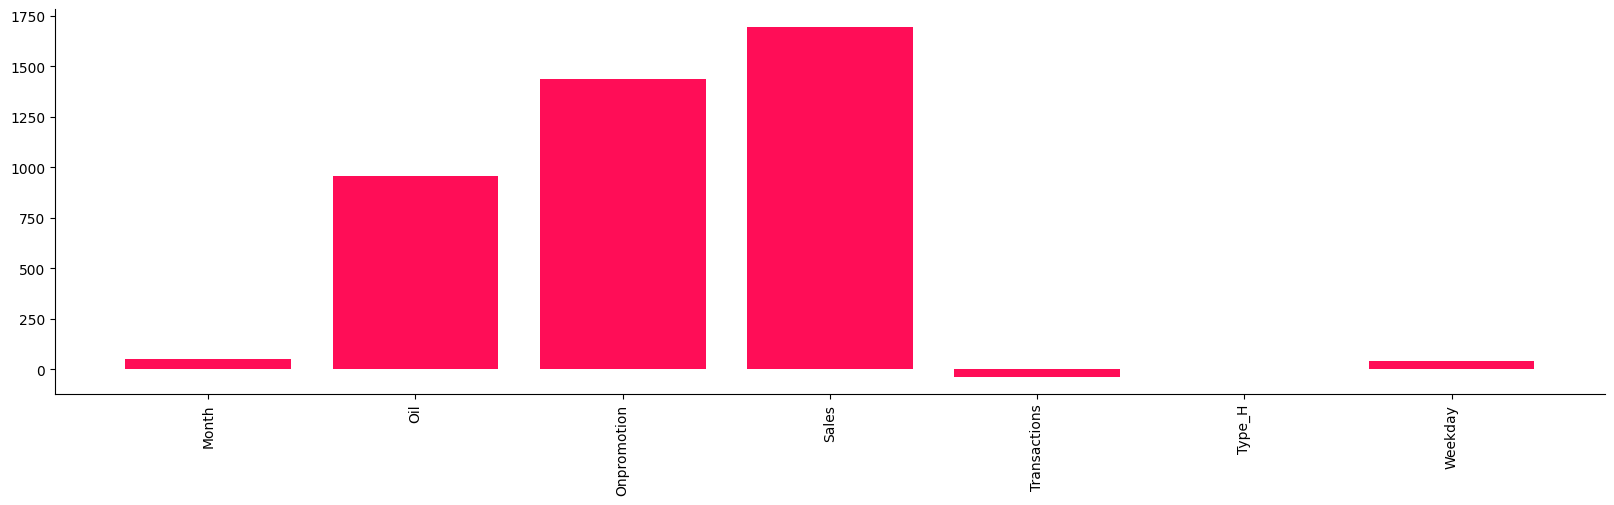

In [ ]:
# Causal model
causal_model = gcm.InvertibleStructuralCausalModel(G)
gcm.auto.assign_causal_mechanisms(causal_model, d_1)
gcm.fit(causal_model, d_1)
# Get change attributions
attribution_scores = gcm.distribution_change(causal_model,
                                     d_1,
                                     d_2,
                                     'Sales',
                                     difference_estimation_func=lambda x, y: np.mean(y) - np.mean(x))
bar_plot(attribution_scores)

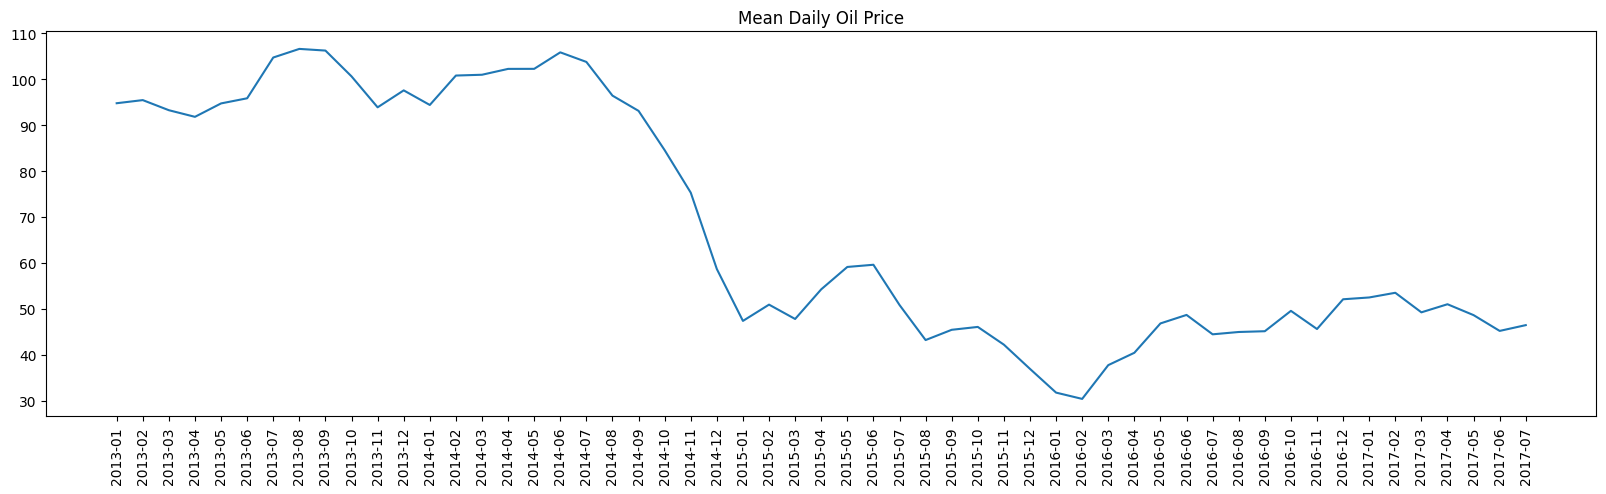

In [ ]:
# Mean daily oil price
s=df.groupby('Y_M')['Oil'].mean()
plt.rcParams['figure.figsize'] = [20, 5]
plt.xticks(rotation=90)
plt.title('Mean Daily Oil Price')
plt.plot(s.index,s)

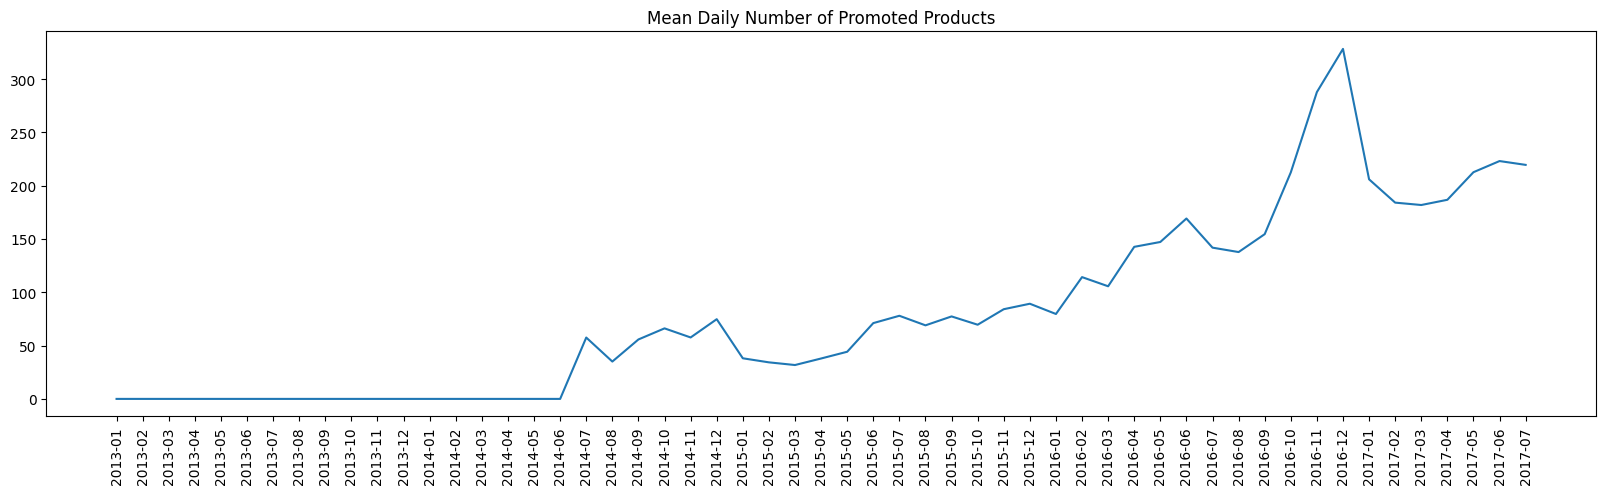

In [ ]:
# Mean daily number of products on promotion
s=df.groupby('Y_M')['Onpromotion'].mean()
plt.rcParams['figure.figsize'] = [20, 5]
plt.xticks(rotation=90)
plt.title('Mean Daily Number of Promoted Products')
plt.plot(s.index,s)

The decreased oil price and increased number of promoted products have a huge impact on the sales, making the sales stable and remaining in high sales.
Moreover, high scores in sales may indicate the growth of business.


I am learning and would greatly appreciate any suggestions. Thank you.

## Package details
https://www.pywhy.org/dowhy/v0.10/index.html